**Loading Dataset**

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

In [4]:
import zipfile
import os
from pathlib import Path

In [5]:
ZIP_FILE = "/content/drive/MyDrive/datasets/potato_filter.zip"
EXTRACT_PATH = Path("dataset")

In [7]:
if os.path.exists(ZIP_FILE):
    print(f"Found zip file at: {ZIP_FILE}")

    with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)

    print("Extracted folder contents:")
    print(os.listdir(EXTRACT_PATH))

    class_folders = os.listdir(EXTRACT_PATH)
    print("Class folders:", class_folders)

    import tensorflow as tf

    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        EXTRACT_PATH / "potato_filter",
        seed=123,
        shuffle=True,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE
    )

else:
    print(f"Error: Zip file not found at {ZIP_FILE}")
    print("Please check the path. Make sure:")
    print("1. Google Drive is mounted")
    print("2. The file exists in /content/drive/MyDrive/datasets/PlantVillage.zip")
    print("3. The file name is spelled correctly")

Found zip file at: /content/drive/MyDrive/datasets/potato_filter.zip
Extracted folder contents:
['potato_filter']
Class folders: ['potato_filter']
Found 2556 files belonging to 2 classes.


In [8]:
class_names = dataset.class_names
print("Class names:", class_names)

Class names: ['none_potato', 'potato']


In [9]:
class_names = dataset.class_names
class_names

['none_potato', 'potato']

In [10]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1]


**Visualize Dataset**

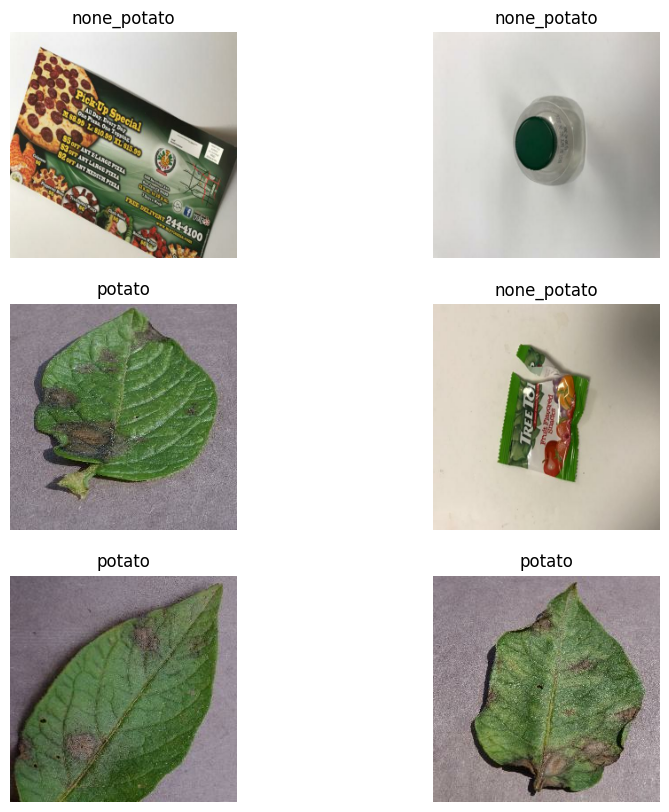

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3, 2, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")